# DUAL MOMENTUM (DM)

In [2]:
import pandas as pd
import itable
import ffn
import talib

%matplotlib inline

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))

In [3]:
def monthly_return_table (daily_prices) :
    #monthly_returns = daily_prices.resample('M').last().pct_change()
    monthly_returns = daily_prices.resample('M', how='last').pct_change()
    df = pd.DataFrame(monthly_returns.values, columns=['Data'])
    df['Month'] = monthly_returns.index.month
    df['Year']= monthly_returns.index.year
    table = df.pivot_table(index='Year', columns='Month').fillna(0).round(4) * 100
    #annual_returns = daily_prices.resample('12M').last().pct_change()[1:].values.round(4) * 100
    annual_returns = daily_prices.resample('12M', how='last').pct_change()[1:].values.round(4) * 100
    if len(table) > len(annual_returns) :
        table = table[1:]
    table['Annual Returns'] = annual_returns
    return table

In [4]:
def endpoints(start=None, end=None, period='m', trading_days=None) :
    
    if trading_days is not None:
        dates = trading_days
# the following 2 lines cause python 3.4.2 to crash, so removed them
#    elif start is not None and end is not None:
#        dates = tradingcalendar.get_trading_days(start, end)
    else:
        print ('\n** ERROR : must either provide pandas series (or df) of trading days \n')
        print ('           or a start and end date\n')
    
    if isinstance(period, int) :
        dates = [dates[i] for i in range(0, len(dates), period)]
    else :    
        if period == 'm' : months = 1
        elif period == 'q' : months = 3
        elif period == 'b' : months = 6
        elif period == 'y' : months = 12           
            
        e_dates = [dates[i - 1] for i in range(1,len(dates))\
                          if dates[i].month > dates[i-1].month\
                          or dates[i].year > dates[i-1].year ]+ list([dates[-1]])
        dates = [e_dates[i] for i in range(0,len(e_dates),months)]
    
    return dates

In [5]:
# THIS ONE MATCHES PV
# SEE PV backtest :https://goo.gl/lBR4K9
# AND spreadsheet : https://goo.gl/8KGp58
# and Quantopian backtest : https://goo.gl/xytT5L

def backtest(prices, weights, capital, offset=1, commission=0.) :
    rebalance_dates = weights.index
    buy_dates = [prices.index[d + offset] for d in range(len(prices.index)-1) if prices.index[d] in rebalance_dates ]
    print ('FIRST BUY DATE = {}\n'.format(buy_dates[0]))
    p_holdings = pd.DataFrame(0, index=prices.index, columns=prices.columns)
    cash = 0.
    for i, date in enumerate(prices.index):
        if date in rebalance_dates :
#             print ('--------------------------------------------------------------------') 
            new_weights = weights.loc[date]
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
        if date in buy_dates :           
            if date == buy_dates[0] :
                p_holdings.loc[date] = (capital * weights.iloc[0] / prices.loc[date])
#                 print ('INIT', cash, p_holdings.iloc[i-1],prices.loc[date], new_weights)
            else :
                portfolio_value = cash + (p_holdings.iloc[i - 1] * prices.loc[date]).sum() * new_weights
                p_holdings.iloc[i] = (portfolio_value / prices.loc[date]).fillna(0)
#                 print ('{} BUY \n{}\n{}\n{}\n{}\n{}\nHOLDINGS\n{}\n'.format(date,cash,portfolio_value,p_holdings.iloc[i-1],
#                                                                     prices.loc[date],new_weights,p_holdings.iloc[i]))
                cash = (portfolio_value - p_holdings.iloc[i] * prices.loc[date]).sum()
#                 print ('{}\nPORTFOLIO VALUE\n{}\nCASH = {}'.format(date, portfolio_value,cash))
        else :
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
            #print ('{} HOLDINGS UNCHANGED'.format(date))

    p_value = (p_holdings * prices).sum(1)[p_holdings.index>=buy_dates[0]]
#     print(p_holdings, )
    p_weights = p_holdings.mul(prices).div(p_holdings.mul(prices).sum(axis=1), axis=0).fillna(0)
    
    return p_value, p_holdings, p_weights

# DM0001

       inception
VWEHX 1980-01-02
VWAHX 1980-01-02
FFXSX 1986-11-10
VCVSX 1986-06-17
VGHCX 1984-05-23
VUSTX 1986-05-19
VWINX 1980-01-02
VFIIX 1980-06-27
FGOVX 1980-01-02
FIRST BUY DATE = 1986-12-31 00:00:00



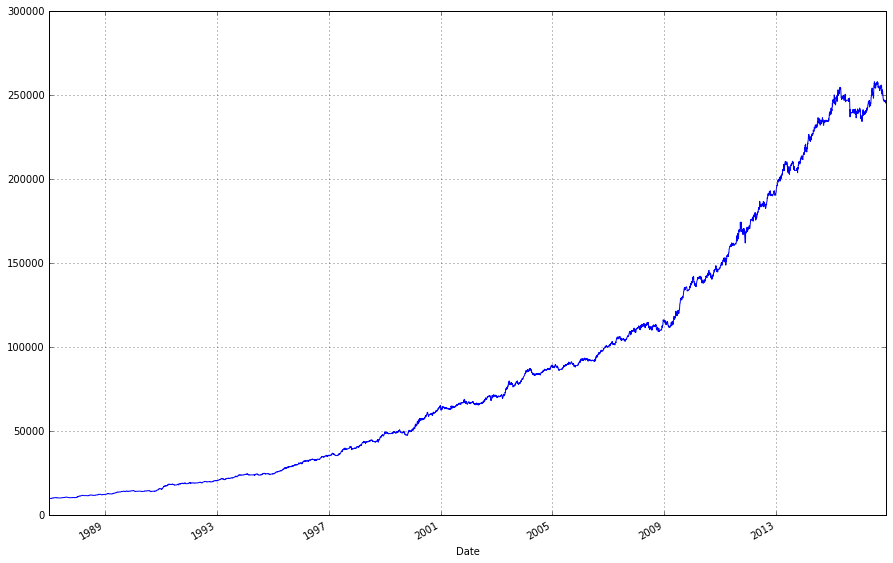

In [6]:
symbols =['VCVSX','VWINX','VWEHX','VGHCX','VUSTX','VFIIX','VWAHX','FGOVX','FFXSX']
cash_proxy = 'CASHX'
risk_free = 'FFXSX'

rs_lookback = 1
risk_lookback = 1
n_top = 3

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [7]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-12-31 00:00:00 - 2016-12-06 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2365.40%            1.83  11.30%  -7.99%

Annualized Returns:
mtd     3m      6m      ytd    1y     3y     5y     10y    incep.
------  ------  ------  -----  -----  -----  -----  -----  --------
-0.12%  -3.55%  -2.71%  1.89%  2.32%  4.90%  7.93%  9.34%  11.30%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.83     1.84       1.56
mean    10.88%   10.90%     11.51%
vol     5.95%    5.93%      7.38%
skew    -0.06    0.16       0.43
kurt    4.81     0.15       -0.50
best    3.79%    6.48%      27.31%
worst   -3.37%   -3.47%     0.47%

Drawdowns:
max     avg       # days
------  ------  --------
-7.99%  -0.93%     19.39

Misc:
---------------  -------
avg. up month    1.83%
avg. down month  -0.92%
up year %        100.00%
12m up %         96

In [12]:
p_value.index

DatetimeIndex(['1986-12-31', '1987-01-02', '1987-01-05', '1987-01-06',
               '1987-01-07', '1987-01-08', '1987-01-09', '1987-01-12',
               '1987-01-13', '1987-01-14',
               ...
               '2016-11-22', '2016-11-23', '2016-11-25', '2016-11-28',
               '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02',
               '2016-12-05', '2016-12-06'],
              dtype='datetime64[ns]', name='Date', length=7547, freq=None)

In [19]:
import empyrical as e
print((e.cagr(p_value.pct_change()[1:]) * 100).round(2))
print((e.sharpe_ratio(p_value.pct_change()[1:])).round(2))
print((e.sortino_ratio(p_value.pct_change()[1:])).round(2))

11.3
1.83
2.78


In [20]:
e.annual_volatility(p_value.pct_change())

0.059470047305524215

In [7]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

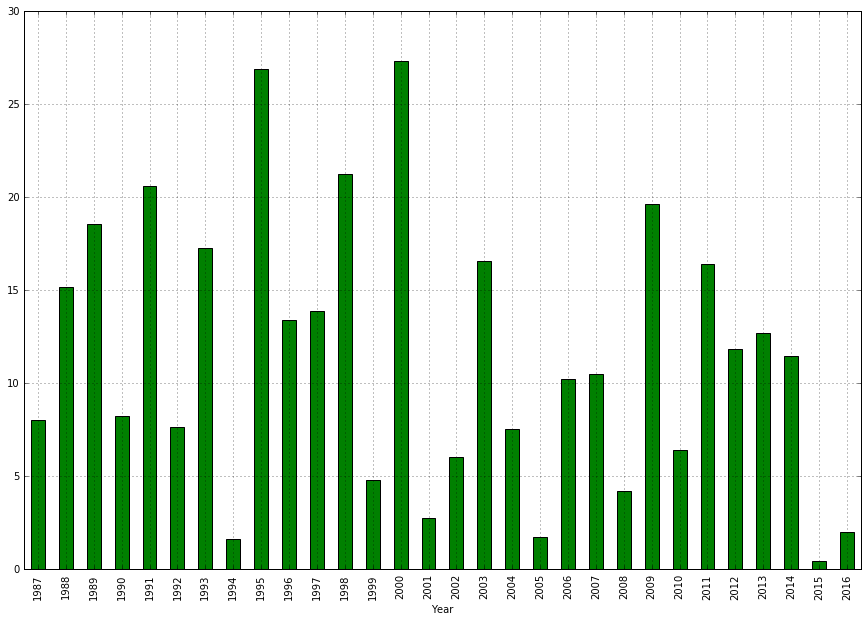

In [8]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# DM0002

       inception
FFXSX 1986-11-10
FRESX 1986-11-14
VGHCX 1986-11-10
VCVSX 1986-11-10
VFIIX 1986-11-10
VUSTX 1986-11-10
VWEHX 1986-11-10
FIRST BUY DATE = 1986-12-31 00:00:00



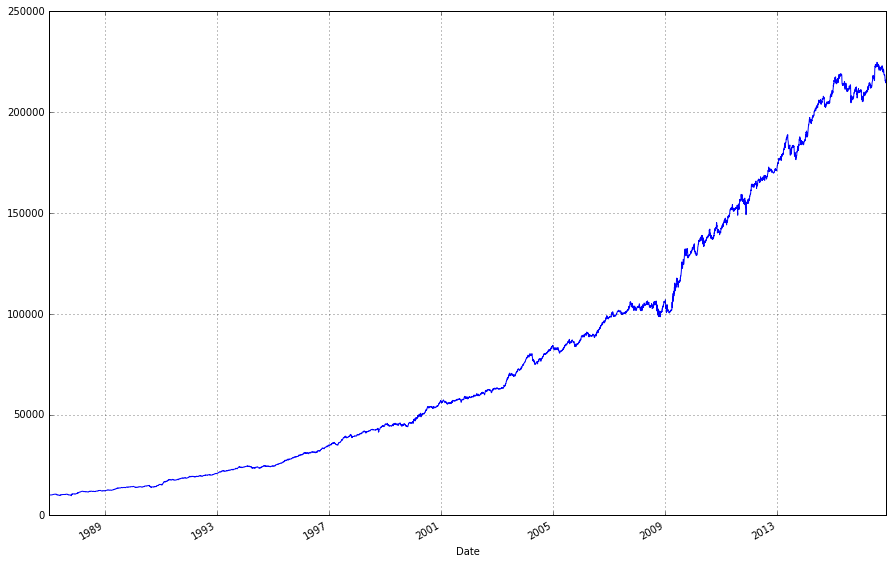

In [9]:
symbols =['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX']
cash_proxy = 'VFIIX'
risk_free = 'FFXSX'

rs_lookback = 1
risk_lookback = 1
n_top = 5

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [10]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-12-31 00:00:00 - 2016-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2045.86%            1.71  10.80%  -7.91%

Annualized Returns:
mtd     3m      6m     ytd    1y     3y     5y     10y    incep.
------  ------  -----  -----  -----  -----  -----  -----  --------
-1.82%  -3.83%  0.79%  1.66%  2.12%  5.07%  7.49%  8.14%  10.80%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.71     1.79       1.56
mean    10.44%   10.46%     10.97%
vol     6.10%    5.84%      7.02%
skew    0.04     -0.01      0.44
kurt    10.92    1.95       -0.67
best    4.98%    8.90%      24.31%
worst   -3.30%   -5.06%     0.69%

Drawdowns:
max     avg       # days
------  ------  --------
-7.91%  -0.83%     17.67

Misc:
---------------  -------
avg. up month    1.59%
avg. down month  -1.19%
up year %        100.00%
12m up %         96.56

In [11]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

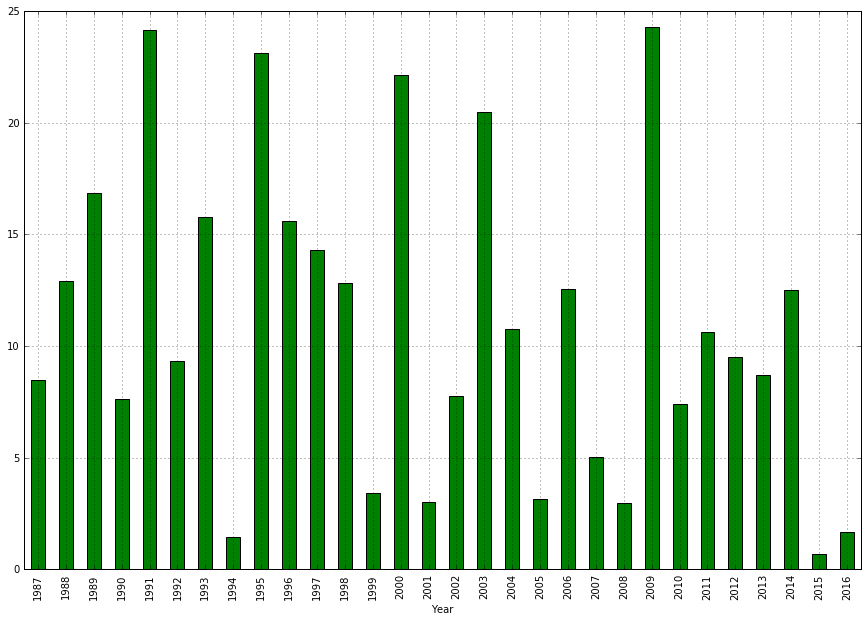

In [12]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# STEP BY STEP BACKTEST

In [417]:
symbols =['VCVSX','VWINX','VWEHX','VGHCX','VFIIX','VWAHX','FGOVX','FFXSX']
cash_proxy = 'VUSTX'
risk_free = 0


# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

In [418]:
data[:3]

,FFXSX,VWINX,VWEHX,VGHCX,VFIIX,FGOVX,VUSTX,VCVSX,VWAHX
Date,,,,,,,,,
1986-11-10,2.362079,2.118463,0.725289,2.850821,1.650580,1.837465,1.307694,1.218052,1.814489
1986-11-11,2.362079,2.119707,0.725289,2.847774,1.650580,1.841068,1.307694,1.218052,1.814489
1986-11-12,2.362079,2.122196,0.726066,2.838631,1.653898,1.841068,1.311594,1.216814,1.817913


In [419]:
prices = data.copy().dropna()
prices[:5]

,FFXSX,VWINX,VWEHX,VGHCX,VFIIX,FGOVX,VUSTX,VCVSX,VWAHX
Date,,,,,,,,,
1986-11-10,2.362079,2.118463,0.725289,2.850821,1.650580,1.837465,1.307694,1.218052,1.814489
1986-11-11,2.362079,2.119707,0.725289,2.847774,1.650580,1.841068,1.307694,1.218052,1.814489
1986-11-12,2.362079,2.122196,0.726066,2.838631,1.653898,1.841068,1.311594,1.216814,1.817913
1986-11-13,2.362079,2.118463,0.726842,2.814252,1.657215,1.844671,1.316793,1.218052,1.821336
1986-11-14,2.362079,2.124686,0.727619,2.817300,1.660533,1.846472,1.320693,1.216814,1.823048


In [420]:
end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

rs_lookback = 1
risk_lookback = 1
n_top = 3

In [421]:
print(symbols)

['VCVSX', 'VWINX', 'VWEHX', 'VGHCX', 'VFIIX', 'VWAHX', 'FGOVX', 'FFXSX']


In [422]:
returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0
if isinstance(risk_free, int) :
    excess_returns = algo_data
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

In [423]:
returns[:3]

,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
1986-12-31,-0.003081,-0.032117,0.004210,-0.054663,0.005719,-0.002187,0.002659,0.002315
1987-01-30,0.048554,0.046097,0.023809,0.151928,0.013589,0.031439,0.009466,0.007580
1987-02-27,0.056158,0.001175,0.018740,0.011527,0.009351,0.004154,0.003434,0.003128


In [424]:
# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0
elligible[:3]

,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
1986-12-31,False,False,True,False,True,False,True,False
1987-01-30,True,True,False,True,False,False,False,False
1987-02-27,True,False,True,True,False,False,False,False


In [425]:
# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)
elligible[:3]

,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
1986-12-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.0
1987-01-30,0.333333,0.333333,0.000000,0.333333,0.000000,0.0,0.000000,0.0
1987-02-27,0.333333,0.000000,0.333333,0.333333,0.000000,0.0,0.000000,0.0


In [426]:
prices.columns

Index(['FFXSX', 'VWINX', 'VWEHX', 'VGHCX', 'VFIIX', 'FGOVX', 'VUSTX', 'VCVSX',
       'VWAHX'],
      dtype='object')

In [427]:
cash_proxy

'VUSTX'

In [428]:
# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[:10]

,FFXSX,VWINX,VWEHX,VGHCX,VFIIX,FGOVX,VUSTX,VCVSX,VWAHX
Date,,,,,,,,,
1986-12-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.333333,0.0,0.000000,0.000000
1987-01-30,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.0,0.333333,0.000000
1987-02-27,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.0,0.333333,0.000000
1987-03-31,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.0,0.000000,0.000000
1987-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1987-05-29,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.000000
1987-06-30,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.333333
1987-07-31,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.333333,0.333333
1987-08-31,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.0,0.333333,0.000000


In [429]:
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)
weights[:10]

,FFXSX,VWINX,VWEHX,VGHCX,VFIIX,FGOVX,VUSTX,VCVSX,VWAHX
Date,,,,,,,,,
1986-12-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000
1987-01-30,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
1987-02-27,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
1987-03-31,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
1987-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1987-05-29,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000
1987-06-30,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333
1987-07-31,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
1987-08-31,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000


In [430]:
date = rebalance_dates[0]
weights.loc[date]

FFXSX    0.000000
VWINX    0.000000
VWEHX    0.333333
VGHCX    0.000000
VFIIX    0.333333
FGOVX    0.333333
VUSTX    0.000000
VCVSX    0.000000
VWAHX    0.000000
Name: 1986-12-31 00:00:00, dtype: float64

In [431]:
prices.loc[date]

FFXSX    2.379192
VWINX    2.085360
VWEHX    0.728181
VGHCX    2.687786
VFIIX    1.692999
FGOVX    1.876035
VUSTX    1.349658
VCVSX    1.209364
VWAHX    1.849020
Name: 1986-12-31 00:00:00, dtype: float64

In [432]:
(10000 * weights.loc[date] / prices.loc[date]).astype(int)

FFXSX       0
VWINX       0
VWEHX    4577
VGHCX       0
VFIIX    1968
FGOVX    1776
VUSTX       0
VCVSX       0
VWAHX       0
Name: 1986-12-31 00:00:00, dtype: int32

FIRST BUY DATE = 1986-12-31 00:00:00



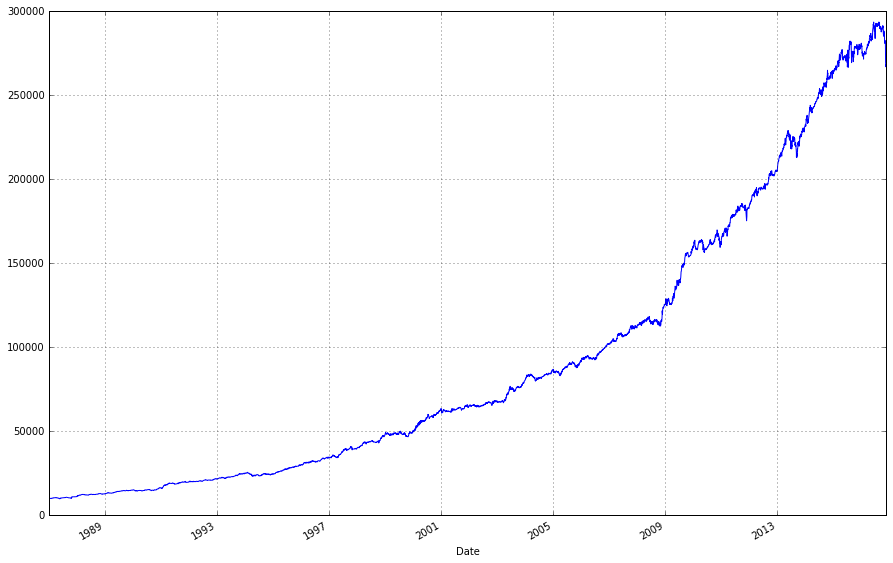

In [433]:
# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)